Bayesian neural networks (BNN) model to estimate uncertainty in medical image analysis.

# Introduction
Neural network modeling has gained popularity in the medical industry as a technique that aids in decision-making based on training with readily available clinical data.  However,  these models rely solely on point estimates to generate weights and bias values, they are incapable of coping with data uncertainty.We cannot accept any tiny inaccuracy produced by a machine learning model when it comes to human life. Bayesian inference is one among the best methods for capturing uncertainty in data. BNN employs the Bayesian inference approach when computing the neural network weights and bias values.
Here I am attempting to create a convolutional neural network using Bayesian inference in my notebook. This model is built with tensorflow probability layers and trained via Bayesian inference. Neural network layers called probabilistic layers have non-deterministic weights. In reality, they are normally distributed random variables that have been sampled differently at each network feedforward phase. Mean and standard deviation, which are trainable parameters, are randomly started for each weight as the layer is being constructed.


**Hypothesis:**
BNN can produce better results in medical image analysis by removing the uncertinity in model predictions. 

In [2]:
import tensorflow as tf 
from glob import glob
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding

import tensorflow as tf
import tensorflow_probability as tfp
import time

In [3]:
# Merge images from different folder to a single folder along with other details. 

base_skin_dir = os.path.join('..', '/kaggle/input/skin-cancer-mnist-ham10000')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Method
For the model, I utilized the data set "The HAM10000 *". The collection contains images of several forms of skin pigmented lesions . The data set includes images of seven different forms of  skin pigmented lesions,
1. Melanocytic nevi
2. Melanoma
3. Benign keratosis-like lesions
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma

The images and patient information are divided into different  folders. Initially, the image information were added to the patient data folder by adding a new column to the patient details data file. Labels were created for each of the aforementioned skin cancer kinds. . All images must be the same size for further processing. The images are resized to a consistent size using the resize option. The neural network model was then generated by using probabilistic layers tfp.layers, such as Convolution2DFlipout and DenseFlipout.

In [4]:
#join the images path to the patient data folder
skin_df = pd.read_csv(os.path.join(base_skin_dir,'/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv'))
skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
#skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
#skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

In [5]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...


In [6]:
#labels are created for each skin cancer types
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df['dx'])
skin_df

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2
...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0


In [7]:
#check for null values in data set
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
path             0
label            0
dtype: int64

There are 57 null values in column age, we can fill that null values with mean values of the age . 

In [8]:
#replace the null values with mean value
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)
skin_df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
path            0
label           0
dtype: int64

In [9]:
#converting the dx accronym name to the corresponding skin cancer type.
dx_types = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}
skin_df['cell_type'] = skin_df['dx'].map(dx_types.get)

<AxesSubplot:>

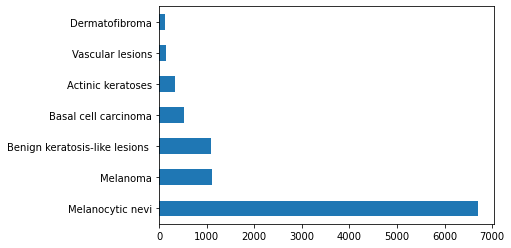

In [10]:
skin_df['cell_type'].value_counts()[:20].plot(kind='barh')

Will load all of the images into the data frame, convert them to an array, then resize them to a fixed size.

In [11]:
SIZE = 32
skin_df['image'] = skin_df['path'].map(lambda x:np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [11]:
skin_df

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,label,cell_type,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2,Benign keratosis-like lesions,"[[[191, 152, 192], [194, 154, 193], [196, 152,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2,Benign keratosis-like lesions,"[[[24, 14, 29], [56, 39, 64], [106, 80, 112], ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2,Benign keratosis-like lesions,"[[[190, 136, 150], [199, 145, 161], [200, 141,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2,Benign keratosis-like lesions,"[[[35, 18, 28], [83, 51, 64], [128, 88, 103], ..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,2,Benign keratosis-like lesions,"[[[155, 110, 135], [188, 139, 168], [210, 157,..."
...,...,...,...,...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0,Actinic keratoses,"[[[181, 164, 179], [179, 162, 176], [180, 163,..."
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0,Actinic keratoses,"[[[4, 5, 3], [24, 22, 21], [101, 88, 88], [128..."
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0,Actinic keratoses,"[[[132, 119, 120], [157, 139, 138], [177, 158,..."
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,0,Actinic keratoses,"[[[160, 123, 144], [163, 131, 152], [166, 128,..."


In [12]:
X = np.asarray(skin_df['image'].tolist())
X/255   # scale the values to a particular scale 

array([[[[0.74901961, 0.59607843, 0.75294118],
         [0.76078431, 0.60392157, 0.75686275],
         [0.76862745, 0.59607843, 0.72156863],
         ...,
         [0.76470588, 0.58431373, 0.62352941],
         [0.77254902, 0.60784314, 0.64313725],
         [0.76078431, 0.59607843, 0.63137255]],

        [[0.76862745, 0.63137255, 0.78039216],
         [0.78431373, 0.63137255, 0.78039216],
         [0.78431373, 0.61960784, 0.74901961],
         ...,
         [0.76470588, 0.58823529, 0.60392157],
         [0.77254902, 0.61568627, 0.64705882],
         [0.75294118, 0.59215686, 0.64313725]],

        [[0.77647059, 0.62352941, 0.77647059],
         [0.78039216, 0.61960784, 0.76078431],
         [0.78823529, 0.61568627, 0.74509804],
         ...,
         [0.77254902, 0.60784314, 0.63137255],
         [0.77647059, 0.62352941, 0.68627451],
         [0.76078431, 0.61176471, 0.69411765]],

        ...,

        [[0.75294118, 0.61568627, 0.75294118],
         [0.8       , 0.6745098 , 0.8       ]

In [13]:
#convert the label values to categorical value
Y = to_categorical(skin_df['label'],num_classes = 7)

In [14]:
#split the whole data into train and test data 
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25,random_state=666)

**Bayesian Model Generation:**

In [13]:
def build_bayesian_bcnn_model(input_shape):
    
    model_in = tf.keras.layers.Input(shape=input_shape)
    #layer 1 
    x = tfp.python.layers.Convolution2DFlipout(32, kernel_size=(3, 3), padding="same", strides=2)(model_in)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    #layer 2
    
    x = tfp.python.layers.Convolution2DFlipout(64, kernel_size=(3, 3), padding="same", strides=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)  
    x = tf.keras.layers.Flatten()(x)
    
    
    x = tfp.python.layers.DenseFlipout(256, activation='relu')(x) 
    model_out = tfp.python.layers.DenseFlipout(7, activation=None)(x)  
    model = tf.keras.Model(model_in, model_out)
    
    return model

In [14]:
#loss function 
def elbo_loss(labels, logits):
    loss_en = tf.nn.softmax_cross_entropy_with_logits(labels, logits)
    loss_kl = tf.keras.losses.KLD(labels, logits)
    loss = tf.reduce_mean(tf.add(loss_en, loss_kl))
    return loss

In [19]:
#bcnn = build_bayesian_bcnn_model(x_train.shape[1:])
optimizer = tf.keras.optimizers.Adam(learning_rate =0.01)

In [20]:
bcnn_model = build_bayesian_bcnn_model(x_train.shape[1:])
bcnn_model.compile(loss=elbo_loss, optimizer= optimizer, metrics=['acc'],
                   experimental_run_tf_function=False)
bcnn_model.summary()
hist = bcnn_model.fit(x_train, y_train,  epochs= 20, verbose=1, validation_split=0.1)

2023-01-09 17:50:46.800874: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2023-01-09 17:50:46.982011: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 16, 16, 32)        1760      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 8, 8, 64)          36928     
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
activation_3 (Activation)    (None, 8, 8, 64)          0   

The training data set and test data set are used to train and verify the BNN model, respectively.The model has learned about the data set and can make predictions on unobserved data using the knowledge gathered during training.

# Results

**Finding uncertinity in predictions**

Here I use the Monte Carlo approach to sample and predict labels 30 times for each picture in the testing set. Then, after obtaining the prediction distribution, we use a threshold to determine that the network should not make any decisions and that the prediction will not be taken into account if its median represents less than the threshold.To forecast a value using the Monte Carlo approach, the median of the labels projected probability must be greater than 0.35 (median value).We then save those predictions on lists in order to display the distribution and get insights.


In [36]:
mc_run = 30
med_prob_thres = 0.35

y_pred_list = [bcnn_model(x_test) for _ in range(mc_run)]  # a list of predicted logits
y_pred_prob_all = np.concatenate([tf.nn.softmax(y, axis=-1)[:, :, np.newaxis] for y in y_pred_list], axis=-1)
y_pred = [[int(np.median(y) >= med_prob_thres) for y in y_pred_prob] for y_pred_prob in y_pred_prob_all]
y_pred = np.array(y_pred)

valid_set = [any(y) for y in y_pred]
print('Number of recognizable samples:', sum(valid_set))

invalid_set = [not any(y) for y in y_pred]
print(' Number of Unrecognizable samples:', sum(invalid_set))

print('Test accuracy on MNIST (recognizable samples):',
      sum(np.equal(np.argmax(y_test[valid_set], axis=-1), np.argmax(y_pred[valid_set], axis=-1))) / len(y_test[valid_set]))



Number of recognizable samples: 2504
 Number of Unrecognizable samples: 0
Test accuracy on MNIST (recognizable samples): 0.6761182108626198


**Accuracy of the model**
The evidence lower bound (ELBO) loss function was utilized. In this case, the loss is determined as a mixture of KL divergence and category cross entropy, as used in NN classification models.

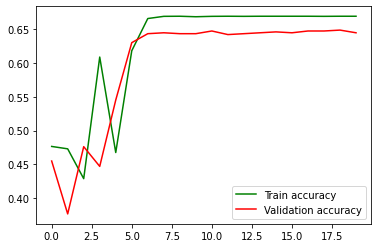

In [39]:
#accuracy per iteration
plt.plot(hist.history['acc'],color='green',label = 'Train accuracy')
plt.plot(hist.history['val_acc'],color='red',label = 'Validation accuracy')
plt.legend()


BNN could be considared as a more complicated variant of neural networks.  I introduced a BNN for diagnosing skin cancer kinds using images in this notebook and estimated the uncertainty in the model predictions. The model achieved an accuracy of 0.67.

# Acknowledgement
* The dataset used for this notebook was downloaded from :Tschandl, Philipp, 2018, "The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions", https://doi.org/10.7910/DVN/DBW86T, Harvard Dataverse, V3, UNF:6:/APKSsDGVDhwPBWzsStU5A== [fileUNF

The dataset from the above link is distribute under the https://creativecommons.org/licenses/by/4.0/ international license, which allowes the free use, distribution, modification and reproduction in any form. 
